In [1]:
rootF = 'D:/Data/Paper defocus/'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
from matplotlib.gridspec import SubplotSpec
import matplotlib.patches as pcs
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.interpolate import interp1d

from shared.LSC_functions import *

# Simulations parameters

## Emmetropic human

In [1]:
simulation = 'Rem20240321_HumanSA_nufft'

imF = rootF + '/Eye model simulations/convolved images/' + str(simulation) + '/'
path_to_PSFs = rootF + '/Eye model simulations/emmetropic human PSFs/' + str(simulation) + '/'

NameError: name 'rootF' is not defined

In [4]:
# Load job ids and optical conditions
simulation_parameters = pd.read_csv(path_to_PSFs + 'JMfile.csv', sep=";")
JobIds = simulation_parameters['JobId'].values

# eye SA
eye_SA_all = simulation_parameters['c04tg'].values
eye_SAs = np.unique(eye_SA_all)
# pup diams
pup_diam_all = simulation_parameters['pupDiam_mm'].values
pup_diams = np.unique(pup_diam_all)
# source eccentricity
sources_ecc_all = simulation_parameters['sourceEccen_deg'].values
sources_ecc = np.unique(sources_ecc_all)
# foveal defocus
offset_file = pd.read_csv(path_to_PSFs + 'offset.csv', sep=";")
offset_um = offset_file['offset_um'].values
offset_um_idx = offset_file['Index'].values
offset_diopters = offset_file['defoc_diopter'].values

print (len(JobIds), 'jobs in simulation', simulation)
print ('Pup diams:', pup_diams)
print ('Source ecc:', sources_ecc)
print ('Foveal defocus um:', offset_um)

Ndfs = len(offset_um)
Npup = len(pup_diams)
NsrcEcc = len(sources_ecc)
NSA = len(eye_SAs)

# Original images
Imgs = ['1','2','3','5']
Nimgs = len(Imgs)

60 jobs in simulation Rem20240321_HumanSA_nufft
Pup diams: [3 5 7]
Source ecc: [ 0 10 20 30]
Foveal defocus um: [-600 -540 -480 -420 -360 -300 -240 -180 -120  -60    0   60  120  180
  240  300  360  420  480  540  600]


In [5]:
delta_diopter = offset_diopters[11]
delta_um = offset_um[11]

print (delta_diopter, delta_um)

delta_1um = delta_diopter/69
lim_in_diopters = offset_diopters[13] + 20*delta_1um

print (offset_um[13], offset_diopters[13])
print ('At 200 µm:', lim_in_diopters, 'D')

-0.20689655172414 60
180 -0.62068965517241
At 200 µm: -0.6806596701649144 D


# Load measures

In [6]:
FovDefocus_indices = np.arange(6,15,1)

print (offset_um[FovDefocus_indices])

[-240 -180 -120  -60    0   60  120  180  240]


## Spherical aberrations

### 500 images

In [7]:
# Load data with SA

data = np.load(rootF + "/contrast analysis/LSC_" + simulation + "_0_500imgs_RF120um_pup5mm_Linux.npz")

local_contrasts = data['contrast']
mean_intensities = data['intensity']
images = data['images']

delta_contrast = local_contrasts[:,:,:,FovDefocus_indices[-1]]- local_contrasts[:,:,:,FovDefocus_indices[0]]

local_contrasts.shape

(500, 5, 4, 21)

### 4 images from experiments

In [8]:
local_contrasts_4imgs = np.load(rootF + "/contrast analysis/" + simulation + "_local_contrast_2sigma_liu2022.pkl", allow_pickle=True)
mean_intensity_4imgs = np.load(rootF + "/contrast analysis/" + simulation + "_mean_intensities_2sigma_liu2022.pkl", allow_pickle=True)

local_contrasts_4imgs.shape # Cen, Imgs, SAs, Eccs, dfs

(1, 4, 5, 4, 21)

## Near vision

### 500 images

In [9]:
simulation_nv = 'Rem20240425_HumanSA_nufft_+4DAcc'
focus_prox = [2.5, 4]

data_nv = np.load(rootF + "/contrast analysis/LSC_" + simulation_nv + "_0_500imgs_RF120um_pup5mm_Linux.npz")

local_contrasts_nv = data_nv['contrast']
mean_intensities_nv = data_nv['intensity']
images_nv = data_nv['images']

delta_contrast_nv = local_contrasts_nv[:,:,:,:,FovDefocus_indices[-1]]- \
                    local_contrasts_nv[:,:,:,:,FovDefocus_indices[0]]

local_contrasts_nv.shape

(500, 5, 2, 4, 21)

### 4 images from experiments

In [10]:
local_contrasts_4imgs_nv = np.load(rootF + "/contrast analysis/" + simulation_nv + "_local_contrast_2sigma_liu2022.pkl", allow_pickle=True)
mean_intensity_4imgs_nv = np.load(rootF + "/contrast analysis/" + simulation_nv + "_mean_intensities_2sigma_liu2022.pkl", allow_pickle=True)

local_contrasts_4imgs_nv.shape # Cen, Imgs, SAs, Prox, Eccs, dfs

(1, 4, 5, 2, 4, 21)

# Figure paper

SA 0 61
no SA 0 473
SA 2 60
no SA 2 127


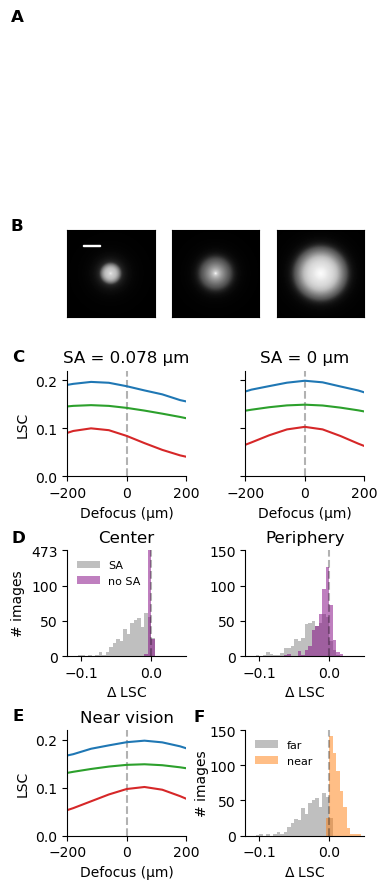

In [11]:
cols = ['C0','C1','C2','C3']
colors_sa = ['grey', 'lightgrey']
retina_ecc = ['Center', 'Periphery']

iCen = 0
idx_ref = 0

true_eye_SAs = [0.0, 0.078]

fig = plt.figure(figsize=(4,9))
GS = fig.add_gridspec(3, 2, height_ratios = [1,1,3])

##### Blank space for eye model illustration

ax = fig.add_subplot(GS[0,:])
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis('off')
ax.text(-0.19, 1, 'A', color='k', fontsize = 12, weight='bold')

### PSFs

gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=GS[1,:], wspace = 0.2, hspace=0.1)

SA = 0.18
iEcc = 0
ecc = sources_ecc[iEcc]
job_id = JobIds[np.where((simulation_parameters['pupDiam_mm'] == 5) & \
                      (simulation_parameters['sourceEccen_deg'] == ecc) & \
                      (simulation_parameters['c04tg'] == SA))[0]][0]

for iDf in [6,10,14]: 
    psf = np.load(path_to_PSFs + 'polychromatic_PSF_Job' + str(int(job_id)).zfill(6) + '_offset' + str(iDf) +\
                       '.npy')
    if iDf == 6:
        ax = fig.add_subplot(gs[0])
        ax.text(-40, 512-128, 'B', color='k', fontsize = 12, weight='bold')
    else:
        ax = fig.add_subplot(gs[int(iDf/6)])
    ax.imshow(np.log(psf+1), origin='lower',cmap='Greys_r')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(128, 512-128)
    ax.set_ylim(128, 512-128)
    # Scale bar
    if iDf == 6:
        scalebar = AnchoredSizeBar(ax.transData,50, '', 'upper left',pad=1,color='white',frameon=False, sep=5, \
                       size_vertical=2)
        ax.add_artist(scalebar)
        
### Exmaple of LSC vs defocus

gs = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=GS[2,:], wspace = 0.5, hspace=0.7)

iPup = 1
iEcc = 0

ax = fig.add_subplot(gs[0,0])
ax.axvline(0, color='k',ls='--',alpha=0.3)
for iImg in [0,2,3]:
    ax.plot(offset_um, local_contrasts_4imgs[iCen,iImg,4,iEcc,:], '-', color=cols[iImg])
ax.set_ylim(0, 0.22)
ax.set_xlim(-200,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('LSC')
ax.set_xlabel('Defocus (µm)')
ax.set_title('SA = 0.078 µm')
ax.text(-385, 0.24, 'C', color='k', fontsize = 12, weight='bold')

ax = fig.add_subplot(gs[0,1])
ax.axvline(0, color='k',ls='--',alpha=0.3)
for iImg in [0,2,3]:
    ax.plot(offset_um, local_contrasts_4imgs[iCen,iImg,0,iEcc,:], '-', color=cols[iImg])
ax.set_ylim(0, 0.22)
ax.set_xlim(-200,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Defocus (µm)')
ax.set_title('SA = 0 µm')
ax.set_yticklabels([])

### Distributions

lim_inf = -0.12
lim_sup = 0.05
bin_size = 0.005
n_bins = int((lim_sup-lim_inf)/bin_size)
bins = np.arange(lim_inf, lim_sup, bin_size)

for iEcc in [0,2]:
    ax = fig.add_subplot(gs[1,int(iEcc/2)])
    ax.axvline(0, color='k',ls='--',alpha=0.3)
    # Normal SA
    ax.hist(delta_contrast[:,4,iEcc], bins=bins, color='grey', alpha=0.5, label = 'SA') #, color=colors[int(iEcc/2)])
    print ('SA', iEcc, max(np.histogram(np.array(delta_contrast[:,4,iEcc]), bins=bins)[0]))
    # No SA
    ax.hist(delta_contrast[:,0,iEcc], bins=bins, color='purple', alpha=0.5, label = 'no SA')
    print ('no SA', iEcc, max(np.histogram(np.array(delta_contrast[:,0,iEcc]), bins=bins)[0]))
    ax.set_xlabel('$\Delta$ LSC')
    ax.set_xlim(-0.12,0.05)
    ax.set_ylim(0, 150)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(retina_ecc[int(iEcc/2)])
    if iEcc == 0:
        ax.text(-0.200, 162.5, 'D', color='k', fontsize = 12, weight='bold')
        ax.set_ylabel('# images')
        ax.set_yticks([0,50,100,150])
        ax.set_yticklabels(['0', '50', '100', '473'])
        ax.legend(frameon=False, fontsize=8, loc = 'upper left')

### Near vision

iPup = 1
iEcc = 0
iProx = 0
iSA = 4

ax = fig.add_subplot(gs[2,0])
ax.axvline(0, color='k',ls='--',alpha=0.3)
for iImg in [0,2,3]:
    ax.plot(offset_um, local_contrasts_4imgs_nv[iCen,iImg,iSA,iProx,iEcc,:], '-', color=cols[iImg])
ax.set_ylim(0, 0.22)
ax.set_xlim(-200,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('LSC')
ax.set_xlabel('Defocus (µm)')
ax.set_title('Near vision')
ax.text(-385, 0.24, 'E', color='k', fontsize = 12, weight='bold')

iEcc = 0
iSA = 4
iProx = 0
ax = fig.add_subplot(gs[2,1])
ax.axvline(0, color='k',ls='--',alpha=0.3)
# far vision
ax.hist(delta_contrast[:,iSA,iEcc], bins=bins, color='grey', alpha=0.5, label = 'far')
# near vision
ax.hist(delta_contrast_nv[:,iSA,iProx,iEcc], bins=bins, color='C1', alpha=0.5, label = 'near') #, color=colors[int(iEcc/2)])
ax.set_xlabel('$\Delta$ LSC')
ax.set_xlim(-0.12,0.05)
ax.set_ylim(0, 150)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('# images', labelpad=0)
ax.legend(frameon=False, fontsize=8, loc = 'upper left')
ax.text(-0.195, 162.5, 'F', color='k', fontsize = 12, weight='bold')

plt.tight_layout()
plt.show()

fsave = 'T:/Documents/Papier defocus/figures/papier/'
# fig.savefig(fsave + 'Fig6_raw.png', format='png', dpi=300, bbox_inches='tight') 